<a href="https://colab.research.google.com/github/promckkon/MK-DCNN/blob/main/MK-DCNN%20with%200dB%20NOISE%20in%20CWRU%20Dataset%202622.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import scipy.io
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

Dataset Input

In [29]:
df=pd.DataFrame(columns=['DE_data','fault']) # upload the dataset on googledrive

for root, dirs, files in os.walk("/content/drive/MyDrive/TRIAX_with_NOISE/TRIAX_Dataset", topdown=False):
    for file_name in files:
        path = os.path.join(root, file_name)
        print(path)

        mat = scipy.io.loadmat(path)

        key_name = list(mat.keys())[3]
        DE_data = mat.get(key_name)
        fault = np.full((len(DE_data), 1), file_name[:-4])

        df_temp = pd.DataFrame({'DE_data':np.ravel(DE_data) , 'fault':np.ravel(fault)})

        df = pd.concat([df,df_temp],axis=0)
        print(df['fault'].unique())

df.to_csv('/content/drive/MyDrive/MK-DCNN CWRU/NOISE_0_faults.csv',index=False)

/content/drive/MyDrive/TRIAX_with_NOISE/TRIAX_Dataset/F8_Normal_100W.mat


/tmp/ipython-input-3316001257.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df_temp],axis=0)


['F8_Normal_100W']
/content/drive/MyDrive/TRIAX_with_NOISE/TRIAX_Dataset/F1_IR007_100W.mat
['F8_Normal_100W' 'F1_IR007_100W']
/content/drive/MyDrive/TRIAX_with_NOISE/TRIAX_Dataset/F2_IR009_100W.mat
['F8_Normal_100W' 'F1_IR007_100W' 'F2_IR009_100W']
/content/drive/MyDrive/TRIAX_with_NOISE/TRIAX_Dataset/F3_IR013_100W.mat
['F8_Normal_100W' 'F1_IR007_100W' 'F2_IR009_100W' 'F3_IR013_100W']
/content/drive/MyDrive/TRIAX_with_NOISE/TRIAX_Dataset/F4_IR017_100W.mat
['F8_Normal_100W' 'F1_IR007_100W' 'F2_IR009_100W' 'F3_IR013_100W'
 'F4_IR017_100W']
/content/drive/MyDrive/TRIAX_with_NOISE/TRIAX_Dataset/F5_OR009_100W.mat
['F8_Normal_100W' 'F1_IR007_100W' 'F2_IR009_100W' 'F3_IR013_100W'
 'F4_IR017_100W' 'F5_OR009_100W']
/content/drive/MyDrive/TRIAX_with_NOISE/TRIAX_Dataset/F6_OR013_100W.mat
['F8_Normal_100W' 'F1_IR007_100W' 'F2_IR009_100W' 'F3_IR013_100W'
 'F4_IR017_100W' 'F5_OR009_100W' 'F6_OR013_100W']
/content/drive/MyDrive/TRIAX_with_NOISE/TRIAX_Dataset/F7_OR017_100W.mat
['F8_Normal_100W' 'F1_IR

# Multi-Kernel Deep 1D-CNN

In [30]:
pip install tensorflow

In [31]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


# Total target rows
TARGET_ROWS = 1800

# Estimate the total number of samples across all fault types
total_samples = sum(len(df[df['fault'] == f]) for f in df['fault'].unique())

# Calculate suitable window size and stride
num_faults = 9
average_samples_per_fault = total_samples / num_faults
approx_windows_per_fault = TARGET_ROWS / num_faults
stride_ratio = 0.8  # Initial stride/window ratio

win_len = int(average_samples_per_fault / approx_windows_per_fault)
stride = int(win_len * stride_ratio)

X=[]
Y=[]


for k in df['fault'].unique():

    df_temp_2 = df[df['fault']==k]

    for i in np.arange(0,len(df_temp_2)-(win_len),stride):
        temp = df_temp_2.iloc[i:i+win_len,:-1].values
        temp = temp.reshape((1,-1))
        X.append(temp)
        Y.append(df_temp_2.iloc[i+win_len,-1])

X=np.array(X)
X=X.reshape((X.shape[0],-1,1))
#X = np.repeat(X, 3, axis=3) # To repeat into 3 chanel format


Y=np.array(Y)
encoder= LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

In [32]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)

Statistical Features

In [33]:
import numpy as np
from scipy.stats import skew, kurtosis
import pandas as pd
import matplotlib.pyplot as plt

# Total target rows
TARGET_ROWS = 1800

# Estimate the total number of samples across all fault types
total_samples = sum(len(df[df['fault'] == f]) for f in df['fault'].unique())

# Calculate suitable window size and stride
num_faults = 9
average_samples_per_fault = total_samples / num_faults
approx_windows_per_fault = TARGET_ROWS / num_faults
stride_ratio = 0.8  # Initial stride/window ratio

WINDOW_SIZE = int(average_samples_per_fault / approx_windows_per_fault)
STRIDE = int(WINDOW_SIZE * stride_ratio)

print(f"Calculated WINDOW_SIZE: {WINDOW_SIZE}, STRIDE: {STRIDE}")

# Initialize a list to store statistical features
statistical_features = []

# Loop through each fault type
for f in df['fault'].unique():
    # Extract data for the current fault type
    fault_data = df[df['fault'] == f].iloc[:, 0].values  # Convert to NumPy array for efficiency

    # Compute windows using sliding window approach
    num_windows = (len(fault_data) - WINDOW_SIZE) // STRIDE + 1
    for i in range(num_windows):
        start = i * STRIDE
        end = start + WINDOW_SIZE
        window = fault_data[start:end]

        # Compute statistical features for the current window
        mean_val = np.mean(window)
        std_val = np.std(window)
        rms_val = np.sqrt(np.mean(np.square(window)))
        max_val = np.max(window)
        min_val = np.min(window)
        skewness_val = skew(window)
        kurtosis_val = kurtosis(window)

        # Additional statistical features
        mean_abs_val = np.mean(np.abs(window))
        form_factor = rms_val / mean_abs_val if mean_abs_val != 0 else 0
        crest_factor = max_val / rms_val if rms_val != 0 else 0

        # Store the features in a dictionary
        statistical_features.append({
            'fault': f,
            'window': i + 1,
            'mean': mean_val,
            'std': std_val,
            'rms': rms_val,
            'max': max_val,
            'min': min_val,
            'skewness': skewness_val,
            'kurtosis': kurtosis_val,
            'form_factor': form_factor,
            'crest_factor': crest_factor
        })

# Convert statistical features into a DataFrame
stat_features_df = pd.DataFrame(statistical_features)

# Display the extracted features and count of rows
print(f"Extracted {len(stat_features_df)} rows (target: {TARGET_ROWS})")
print(stat_features_df)

# Save the extracted features to a CSV file
output_file = "/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_statistical_features_with_form_and_crest_factors.csv"
stat_features_df.to_csv(output_file, index=False)
print(f"Statistical features saved to '{output_file}'.")


Calculated WINDOW_SIZE: 614, STRIDE: 491
Extracted 2246 rows (target: 1800)
               fault  window      mean       std       rms     max     min  \
0     F8_Normal_100W       1 -0.035424  0.072612  0.080792  0.2142 -0.2001   
1     F8_Normal_100W       2 -0.034781  0.077889  0.085302  0.2251 -0.2911   
2     F8_Normal_100W       3 -0.029623  0.077824  0.083271  0.2251 -0.2082   
3     F8_Normal_100W       4 -0.034251  0.075439  0.082850  0.1834 -0.2162   
4     F8_Normal_100W       5 -0.033003  0.080657  0.087148  0.2503 -0.2936   
...              ...     ...       ...       ...       ...     ...     ...   
2241   F7_OR017_100W     273 -0.090554  0.593991  0.600853  1.3945 -1.9392   
2242   F7_OR017_100W     274 -0.121906  0.594206  0.606583  1.5230 -1.9392   
2243   F7_OR017_100W     275 -0.133987  0.620392  0.634696  1.4503 -2.0480   
2244   F7_OR017_100W     276 -0.152632  0.597443  0.616632  1.3486 -2.0480   
2245   F7_OR017_100W     277 -0.129839  0.564983  0.579710  1.4429

In [34]:
import pandas as pd
from sklearn.utils import resample

# Load your dataset (replace 'your_dataset.csv' with your actual file)
df = pd.read_csv('/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_statistical_features_with_form_and_crest_factors.csv')

# Display initial class distribution
print("Initial class distribution:")
print(df['fault'].value_counts())

# Target size for undersampling/resampling
TARGET_ROWS = 1570

# Separate all fault types
fault_classes = df['fault'].value_counts()

# Determine the number of classes
num_classes = len(fault_classes)

# Calculate how many samples to take from each class
samples_per_class = TARGET_ROWS // num_classes

# Initialize a list to store resampled data
resampled_data = []

# Loop over each class to resample them
for fault_class in fault_classes.index:
    class_data = df[df['fault'] == fault_class]
    if len(class_data) > samples_per_class:
        # Undersample
        class_data_resampled = resample(class_data, replace=False, n_samples=samples_per_class, random_state=42)
    else:
        # Upsample
        class_data_resampled = resample(class_data, replace=True, n_samples=samples_per_class, random_state=42)

    resampled_data.append(class_data_resampled)

# Concatenate the resampled data into a single DataFrame
balanced_df = pd.concat(resampled_data)

# Check if we have the exact number of rows
current_rows = len(balanced_df)
print(f"Current rows after equal resampling: {current_rows}")

# If the current rows don't match the target rows, adjust by trimming or adding rows
if current_rows > TARGET_ROWS:
    # Trim extra rows (if more than target)
    balanced_df = balanced_df.head(TARGET_ROWS)
elif current_rows < TARGET_ROWS:
    # Add rows if fewer than target, by sampling from existing data
    remaining_rows = TARGET_ROWS - current_rows
    additional_data = balanced_df.sample(n=remaining_rows, replace=True, random_state=42)
    balanced_df = pd.concat([balanced_df, additional_data])

# Shuffle the final dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Display new class distribution
print("New class distribution:")
print(balanced_df['fault'].value_counts())

# Display final row count
print(f"Final row count: {len(balanced_df)}")

# Save the balanced dataset to a CSV file
balanced_df.to_csv("/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_balanced_dataset_equal_resampling_exact_1570.csv", index=False)
print("Balanced dataset saved as '/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_balanced_dataset_equal_resampling_exact_1570.csv'")


Initial class distribution:
fault
F2_IR009_100W     310
F1_IR007_100W     291
F3_IR013_100W     291
F5_OR009_100W     286
F4_IR017_100W     281
F7_OR017_100W     277
F6_OR013_100W     269
F8_Normal_100W    241
Name: count, dtype: int64
Current rows after equal resampling: 1568
New class distribution:
fault
F8_Normal_100W    197
F7_OR017_100W     197
F3_IR013_100W     196
F4_IR017_100W     196
F2_IR009_100W     196
F1_IR007_100W     196
F5_OR009_100W     196
F6_OR013_100W     196
Name: count, dtype: int64
Final row count: 1570
Balanced dataset saved as '/content/drive/MyDrive/MK-DCNN CWRU/NNOISE_0_balanced_dataset_equal_resampling_exact_1570.csv'


In [35]:
balanced_df.shape

(1570, 11)

In [36]:
balanced_df=balanced_df.sort_values(by='fault')

In [37]:
balanced_df

,fault,window,mean,std,rms,max,min,skewness,kurtosis,form_factor,crest_factor
1220,F1_IR007_100W,120,-0.052678,0.446282,0.449380,1.3909,-1.3762,0.011334,0.122564,1.262388,3.095150
1358,F1_IR007_100W,227,-0.021342,0.436472,0.436994,1.5834,-1.2266,0.202876,0.073287,1.238257,3.623393
1511,F1_IR007_100W,31,-0.039718,0.455725,0.457453,1.3496,-1.4497,0.020159,0.031912,1.245652,2.950250
714,F1_IR007_100W,101,-0.055891,0.442445,0.445962,1.4185,-1.2281,0.057374,0.069832,1.259370,3.180767
710,F1_IR007_100W,174,-0.055893,0.429799,0.433418,1.1926,-1.3136,0.002331,-0.163883,1.244514,2.751616
...,...,...,...,...,...,...,...,...,...,...,...
1376,F8_Normal_100W,228,-0.036189,0.080373,0.088145,0.2277,-0.2373,0.042807,-0.108428,1.247545,2.583244
663,F8_Normal_100W,225,-0.034162,0.081456,0.088330,0.1866,-0.2244,0.017451,-0.565571,1.221653,2.112536
660,F8_Normal_100W,81,-0.031458,0.075856,0.082121,0.2172,-0.2300,0.165824,-0.374555,1.207042,2.644892
421,F8_Normal_100W,220,-0.029965,0.077292,0.082898,0.1732,-0.2042,0.162483,-0.443879,1.225486,2.089326


     t-SNE 1    t-SNE 2          fault
0  10.576097  23.503271  F1_IR007_100W
1  -5.843844  16.441458  F1_IR007_100W
2   3.009470  24.061182  F1_IR007_100W
3  10.999225  27.395275  F1_IR007_100W
4   0.780288  19.115728  F1_IR007_100W


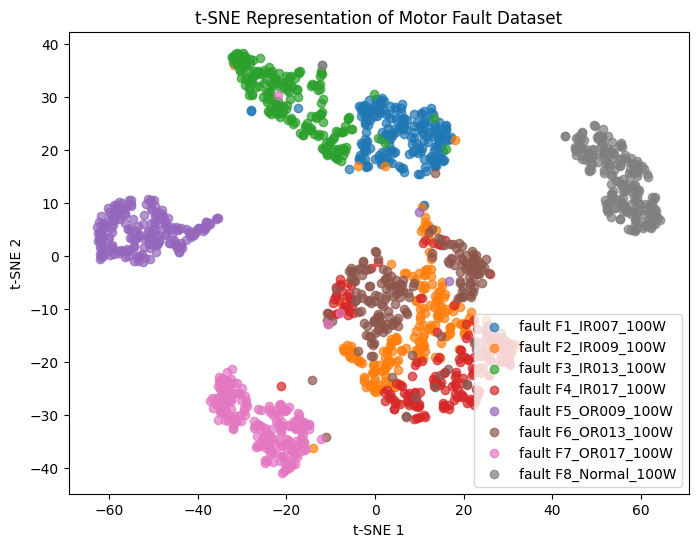

In [38]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Sort the dataset by the 'Fault' column
balanced_df = balanced_df.sort_values(by='fault')

# Separate features and target variable
X = balanced_df.drop(columns=['fault'])  # Replace 'Fault' with actual target column name
y = balanced_df['fault']

# Normalize the feature columns using StandardScaler
scaler = StandardScaler()
X_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Concatenate the normalized features with the target variable
STAT_Motor_Fault_dataset_normalized = pd.concat([X_normalized, y.reset_index(drop=True)], axis=1)

# Sort the normalized dataset by 'Fault' column
STAT_Motor_Fault_dataset_normalized = STAT_Motor_Fault_dataset_normalized.sort_values(by='fault')

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)  # 2D t-SNE
X_tsne = tsne.fit_transform(X_normalized)

# Create a DataFrame for t-SNE results
tSNE_representation = pd.DataFrame(X_tsne, columns=['t-SNE 1', 't-SNE 2'])
tSNE_representation['fault'] = y.reset_index(drop=True)

# Display the t-SNE representation
print(tSNE_representation.head())

# Optional: Visualization of t-SNE representation
plt.figure(figsize=(8, 6))
for label in tSNE_representation['fault'].unique():
    subset = tSNE_representation[tSNE_representation['fault'] == label]
    plt.scatter(subset['t-SNE 1'], subset['t-SNE 2'], label=f'fault {label}', alpha=0.7)

plt.title('t-SNE Representation of Motor Fault Dataset')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.show()


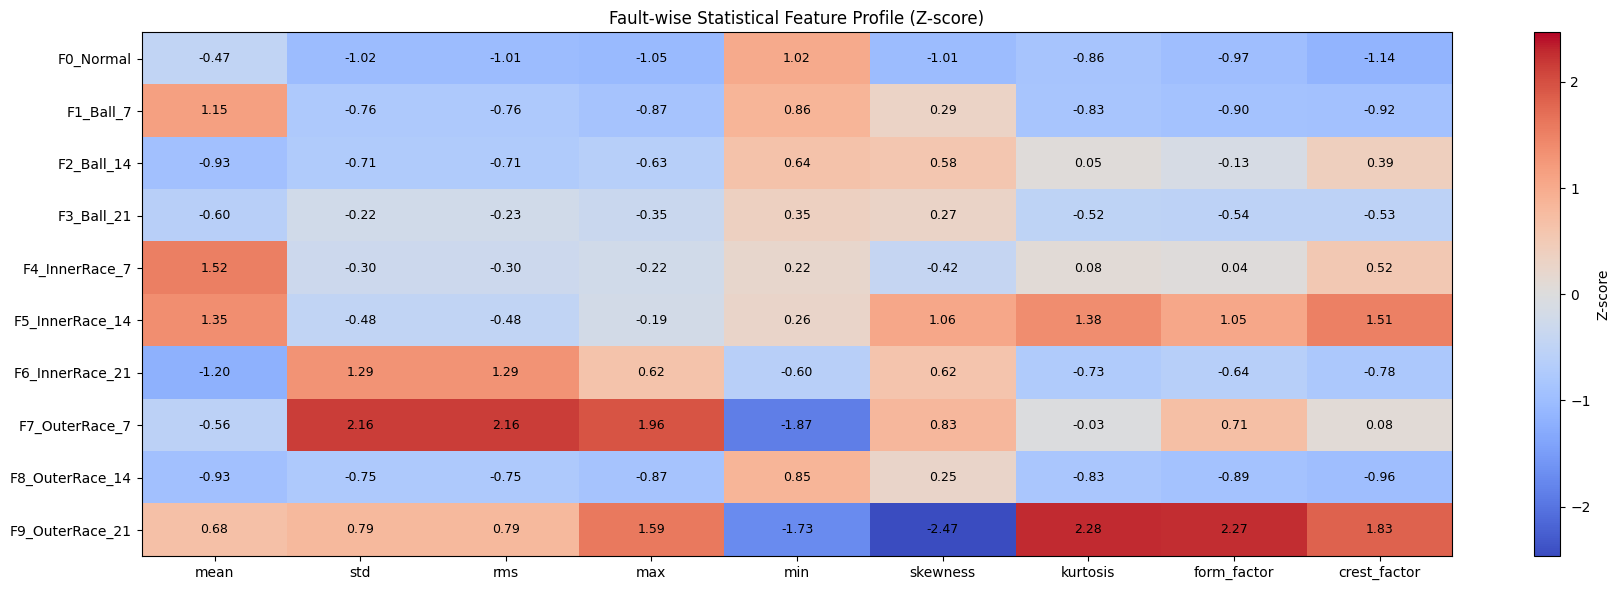

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

vals = fault_profile_z.values
vmax = np.max(np.abs(vals))
norm = TwoSlopeNorm(vmin=-vmax, vcenter=0, vmax=vmax)

plt.figure(figsize=(18, 6))
im = plt.imshow(
    vals,
    aspect="auto",
    cmap="coolwarm",
    norm=norm
)
plt.colorbar(im, label="Z-score")

plt.xticks(
    range(len(fault_profile_z.columns)),
    fault_profile_z.columns,
    rotation=0,
    ha="center"
)
plt.yticks(
    range(len(fault_profile_z.index)),
    fault_profile_z.index
)

plt.title("Fault-wise Statistical Feature Profile (Z-score)")

for i in range(vals.shape[0]):
    for j in range(vals.shape[1]):
        plt.text(
            j, i,
            f"{vals[i, j]:.2f}",
            ha="center",
            va="center",
            fontsize=9,
            color="black"
        )

plt.tight_layout()
plt.savefig(
    "Faultwise_Statistical_Feature_Profile_Zscore.png",
    dpi=600,
    bbox_inches="tight"
)
plt.show()


In [40]:
feature_cols = [c for c in balanced_df.columns if c not in ["fault", "window"]]

def pick_representative(df):
    mean_vec = df[feature_cols].mean()
    dist = ((df[feature_cols] - mean_vec) ** 2).sum(axis=1)
    return df.loc[dist.idxmin()]

one_sample_per_fault = (
    balanced_df
    .groupby("fault", group_keys=False)
    .apply(pick_representative)
    .reset_index(drop=True)
)

one_sample_per_fault


/tmp/ipython-input-69028754.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(pick_representative)


,fault,window,mean,std,rms,max,min,skewness,kurtosis,form_factor,crest_factor
0,F1_IR007_100W,173,-0.043742,0.430525,0.432741,1.3251,-1.3136,0.090145,-0.002221,1.242059,3.062106
1,F2_IR009_100W,291,-0.100616,0.447546,0.458717,1.1794,-1.2652,0.078139,-0.386954,1.222978,2.571085
2,F3_IR013_100W,148,-0.046753,0.430618,0.433149,1.2239,-1.7282,-0.132833,0.798158,1.290350,2.825589
3,F4_IR017_100W,6,-0.112664,0.469131,0.482470,1.2564,-1.4992,0.007306,-0.080139,1.257221,2.604101
4,F5_OR009_100W,265,-0.063332,0.969369,0.971435,2.0480,-2.0480,-0.250776,0.029595,1.326906,2.108221
5,F6_OR013_100W,163,-0.088654,0.521585,0.529066,1.4379,-1.5959,0.064692,-0.304034,1.232566,2.717809
6,F7_OR017_100W,117,-0.117490,0.615662,0.626772,1.5996,-2.0480,-0.207238,0.097343,1.252613,2.552124
7,F8_Normal_100W,33,-0.034384,0.073958,0.081560,0.2019,-0.2237,0.210116,-0.057002,1.229377,2.475485
